# Nettoyage des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install unidecode

In [ ]:
import pandas as pd
import unidecode
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
import re

# Base des lieux et équipements culturels

In [ ]:
# Chargement des données
equipements_cult = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-des-lieux-et-des-equipements-culturels.csv',sep=";")

<ipython-input-338-4f66bd515cd2>:2: DtypeWarning: Columns (14,22,23,29,30,33,34,41,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  equipements_cult = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-des-lieux-et-des-equipements-culturels.csv',sep=";")


In [ ]:
# Formatage des noms de colonnes
equipements_cult.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", "_").replace("-","_").replace(",","_")
    for col in equipements_cult.columns
]

## Sélection des données

In [ ]:
# Choix des colonnes utiles
col = ['NOM','LIBELLE_GEOGRAPHIQUE','SOUS_DOMAINE','CODE_POSTAL','DOMAINE','GCD','LONGITUDE','LATITUDE','NOMBRE_FAUTEUILS_DE_CINEMA','NOMBRE_ECRANS','SURFACE_BIBLIOTHEQUE','JAUGE_DU_THEATRE']
equipements_cult = equipements_cult[col]

In [ ]:
# Affectation des noms de colonnes
equipements_cult.rename(columns={'LIBELLE_GEOGRAPHIQUE': 'COMMUNE'}, inplace=True)

## Correction de donnée

### Correction d'une Longitude

Lors de notre parcours des données, nous avons remarqué qu'une des longitude était mal renseignée. En effet, elle contient une virgule au lieu d'un point.

In [ ]:
# Recherche de l'index de la donnée
index = equipements_cult.index[equipements_cult['LONGITUDE'] == '-61,532888'].tolist()
index

[9559]

In [ ]:
# Correction de la donnée
equipements_cult.loc[index, 'LONGITUDE'] = -61.532888

# Vérification du chamgement
equipements_cult.iloc[index]

,NOM,COMMUNE,SOUS_DOMAINE,CODE_POSTAL,DOMAINE,GCD,LONGITUDE,LATITUDE,NOMBRE_FAUTEUILS_DE_CINEMA,NOMBRE_ECRANS,SURFACE_BIBLIOTHEQUE,JAUGE_DU_THEATRE
9559,Association Cine Woule,Pointe-à-Pitre,Musée,97110.0,Patrimoine,2 - Centres urbains intermédiaires,-61.532888,16.240659,NaN,NaN,NaN,NaN


### Gestion d'une Commune

Lors de notre parcours des données, nous avons remarqué que l'une des ligne contenait une Commune du nom de '0'. Pour afin d'éviter les erreurs par la suite, nous avons décidé de supprimer cette ligne.

In [ ]:
# Suppression de la ligne
equipements_cult = equipements_cult.drop(equipements_cult[equipements_cult['COMMUNE'] == 0].index)

## Gestion des données manquantes

NOM                            0.000000
COMMUNE                        0.000000
SOUS_DOMAINE                   0.000000
CODE_POSTAL                    0.000000
DOMAINE                        0.000000
GCD                            0.000000
LONGITUDE                      0.000000
LATITUDE                       0.000000
NOMBRE_FAUTEUILS_DE_CINEMA    97.027729
NOMBRE_ECRANS                 97.026355
SURFACE_BIBLIOTHEQUE          99.443215
JAUGE_DU_THEATRE              98.568856
dtype: float64


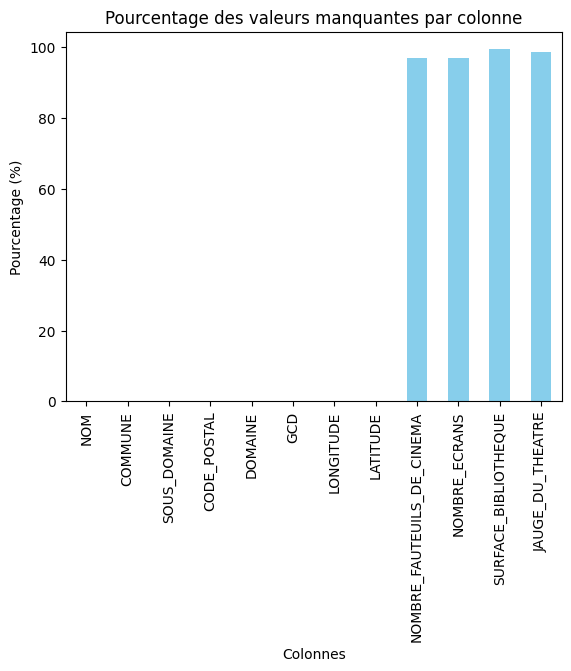

In [ ]:
# Pourcentage de données manquantes par colonnes

# Calcul du pourcentage des valeurs manquantes
missing_percentage = (equipements_cult.isna().sum() / len(equipements_cult)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

Il y a des données manquantes dans certaines colonnes comme NOMBRE_FAUTEUILS_DE_CINEMA car dans ce fichier toutes les lignes ne sont pas des cinémas, pareil pour les autres 3 autres. Le problème va être résolu dans la base de données car les différents types vont être regroupés ensemble.

### Gestion des codes postaux manquants

In [ ]:
# On retire les colonnes dont les codes postaux sont manquants (peu nombreux)
equipements_cult = equipements_cult[~equipements_cult.CODE_POSTAL.isna()]

### Gestion des coordonnées manquantes

In [ ]:
# Suppression des lignes dont il manque les coordonnées
equipements_cult = equipements_cult[~equipements_cult.LONGITUDE.isna()]

### Gestion des GCD manquants

In [ ]:
# Suppression des lignes (0.1%)
equipements_cult = equipements_cult[~equipements_cult.GCD.isna()]

### Gestion des sous-domaines manquant

#### Harmonisation des sous-domaines

In [ ]:
# Observation des différentes modalités dans SOUS_DOMAINE
equipements_cult['SOUS_DOMAINE'].value_counts()

,count
SOUS_DOMAINE,
Monument,47275
Musée,1509
Archéologie,886
Théâtre,885
"Danse,Musique,Théâtre",677
Musique,151
Arts visuels,60
Danse,34
Architecture,21


In [ ]:
# Regroupement des colonnes pour en faire des classes :
remplacements = {
    "Monument":"Monument",
    "Musée" : "Musee",
    "Théâtre" : "Théâtre",
    "Archéologie" : "Archéologie",
    "Danse,Musique,Théâtre": "Danse,Musique,Theatre",
    "Musique" : "Musique",
    "Arts visuels" : "Arts visuels",
    "Danse" : "Danse",
    "Arts du cirque" : "Cirque",
    "Spectacle vivant,Théâtre": "Théâtre",
    "Spectacle vivant,Musique,Danse" : "Danse,Musique,Theatre" ,
    "Musique,Danse" : "Danse,Musique,Theatre",
    "Marionnette" : "Marionnette",
    "Architecture" : "Architecture",
    "Arts de la rue" : "Arts de la rue",
    "Spectacle vivant,Musique" : "Musique",
    "Musique,Danse,Théâtre" : "Musique,Danse,Théâtre",
    "Spectacle vivant,Cirque" : "Cirque",
    "Spectacle vivant,Danse" : "Danse",
    "Patrimoine" : "Patrimoine",
    "Cinéma, audiovisuel" : "Cinéma, audiovisuel",
    "Musique,Danse,Théâtre,Arts plastiques" : "Musique,Danse,Théâtre",
    "Spectacle vivant,Marionnette" : "Marionnette",
    "Musique,Danse-Théâtre,Arts plastiques" : "Danse,Musique,Theatre"
}

# Appliquer la fonction
equipements_cult['SOUS_DOMAINE'] = equipements_cult['SOUS_DOMAINE'].map(remplacements)

In [ ]:
# Observation des différentes modalités dans SOUS_DOMAINE
equipements_cult['SOUS_DOMAINE'].value_counts()

,count
SOUS_DOMAINE,
Monument,47275
Musee,1509
Théâtre,896
Archéologie,886
"Danse,Musique,Theatre",696
Musique,158
Arts visuels,60
Danse,38
Architecture,21


In [ ]:
# Les sous-domaines manquant sont remplacés par leur domaine
sous_dom = []
for i in range(len(equipements_cult.SOUS_DOMAINE)):
    if pd.isna(equipements_cult['SOUS_DOMAINE'].iloc[i]):
        sous_dom.append(equipements_cult['DOMAINE'].iloc[i])
    else:
        sous_dom.append(equipements_cult['SOUS_DOMAINE'].iloc[i])

equipements_cult.SOUS_DOMAINE = sous_dom

## Gestion des accents dans les données


In [ ]:
# On réindexe les données
equipements_cult.reset_index(drop=True, inplace=True)

list_of_changes = [
    (' *', ''),
    ('É', 'E'),
    ('È', 'E'),
    ('Ê', 'E'),
    ('Ë', 'E'),
    ('Á', 'A'),
    ('Â', 'A'),
    ('À', 'A'),
    ('Ô', 'O'),
    ('Ù', 'U'),
    ('Î', 'I'),
    ('Ï', 'I'),
    (' ', '_'),
    ("\'", '_'),
    (',', ''),
    ('’', '_')
                   ]
def replace_multiple(string, l):
    for i in range(len(l)):
        string = string.replace(l[i][0], l[i][1])
    return string

for i in range(len(equipements_cult)):
    equipements_cult.loc[i, 'NOM'] = replace_multiple(equipements_cult.loc[i, 'NOM'], list_of_changes)
    equipements_cult.loc[i, 'COMMUNE'] = replace_multiple(equipements_cult.loc[i, 'COMMUNE'], list_of_changes)
    equipements_cult.loc[i, 'LATITUDE'] = float(equipements_cult.loc[i, 'LATITUDE'])
    equipements_cult.loc[i, 'LONGITUDE'] = float(equipements_cult.loc[i, 'LONGITUDE'])


In [ ]:
equipements_cult.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/base-des-lieux-et-des-equipements-culturels.csv', index=False)

# Immeubles protégés au titre de Monument Historiques

In [ ]:
# Chargement des données
Monuments_Historiques = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/liste-des-immeubles-proteges-au-titre-des-monuments-historiques.csv',sep=";")

<ipython-input-368-cc04f05840c5>:2: DtypeWarning: Columns (15,16,23,26,42,53,55,58,59,61,71) have mixed types. Specify dtype option on import or set low_memory=False.
  Monuments_Historiques = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/liste-des-immeubles-proteges-au-titre-des-monuments-historiques.csv',sep=";")


##Sélection des données

In [ ]:
# Sélection des colonnes
col = ['Titre_editorial_de_la_notice', 'COG_Insee_lors_de_la_protection', 'Commune_forme_index', 'Lien_vers_la_base_Archiv_MH', 'coordonnees_au_format_WGS84']
Monuments_Historiques = Monuments_Historiques[col]

In [ ]:
# Nom des colonnes modifiées sans espace, virgule, ' etc...
Monuments_Historiques.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", " ")
    for col in Monuments_Historiques.columns
]


In [ ]:
# Séparation des coordonnées en longitude et latitude
Monuments_Historiques[['LATITUDE', 'LONGITUDE']] = Monuments_Historiques['COORDONNEES_AU_FORMAT_WGS84'].str.split(',', expand=True)
Monuments_Historiques = Monuments_Historiques.drop('COORDONNEES_AU_FORMAT_WGS84', axis=1)

In [ ]:
# Renommer les colonnes
Monuments_Historiques.rename(columns={'TITRE_EDITORIAL_DE_LA_NOTICE' : 'NOM',
                   'COG_INSEE_LORS_DE_LA_PROTECTION':'CODE_INSEE',
                   'COMMUNE_FORME_INDEX' : 'COMMUNE',
                   'LIEN_VERS_LA_BASE_ARCHIV_MH' : 'URL'}, inplace=True)

##Gestion des données manquantes

NOM            0.0
COMMUNE        0.0
URL            0.0
CODE_POSTAL    0.0
LATITUDE       0.0
LONGITUDE      0.0
dtype: float64


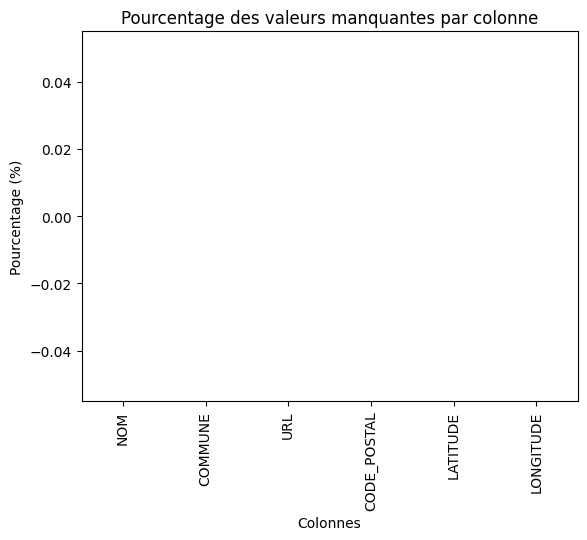

In [ ]:
# Pourcentage de données manquantes par colonnes

# Calcul du pourcentage des valeurs manquantes
missing_percentage = (Monuments_Historiques.isna().sum() / len(Monuments_Historiques)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

###Gestion des URL manquants

In [ ]:
# Remplacement des URL Manquants par 'non renseigné'
Monuments_Historiques.URL = Monuments_Historiques.URL.fillna("non renseigne")

### Gestion des des coordonnées manquantes

In [ ]:
# Nombre de lignes dont il manque les coordonnées géographiques
Monuments_Historiques['LONGITUDE'].isna().sum()

2405

In [ ]:
# Chargement des données
df_coord = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-officielle-codes-postaux.csv',sep=";")
df_coord = df_coord.drop_duplicates(subset=['code_commune_insee'])

# Séparation des coordonnées en longitude et latitude
df_coord[['LATITUDE', 'LONGITUDE']] = df_coord['_geopoint'].str.split(',', expand=True)
df_coord = df_coord.drop('_geopoint', axis=1)

col = ['code_commune_insee', 'LATITUDE', 'LONGITUDE']
df_coord = df_coord[col]


In [ ]:
# Séparation de la df pour gérer les manquants
df_sans_nan = Monuments_Historiques[~Monuments_Historiques.LATITUDE.isna()]
df_avec_nan = Monuments_Historiques[Monuments_Historiques.LATITUDE.isna()]


In [ ]:
# Merge sur le code commune INSEE pour ajouter les valeurs manquantes
df_avec_nan = df_avec_nan.merge(df_coord, how = 'left', left_on = 'CODE_INSEE', right_on = 'code_commune_insee')

# On récupère les bonnes colonnes
col = ['NOM', 'COMMUNE','URL', 'CODE_INSEE', 'LATITUDE_y', 'LONGITUDE_y']
df_avec_nan = df_avec_nan[col]

# On renomme les colonnes
df_avec_nan = df_avec_nan.rename(columns={'LATITUDE_y': 'LATITUDE',
                                          'LONGITUDE_y': 'LONGITUDE'})

In [ ]:
# Re fusion des deux parties
Monuments_Historiques = pd.concat([df_avec_nan, df_sans_nan])

In [ ]:
# Nombre de lignes avec NAN restantes
Monuments_Historiques['LONGITUDE'].isna().sum()

322

In [ ]:
# Suppression des dernières lignes dont il manque les coordonnées
Monuments_Historiques = Monuments_Historiques[~Monuments_Historiques.LATITUDE.isna()]

### Gestion des communes manquantes

In [ ]:
# Nombre de communes manquantes
Monuments_Historiques['COMMUNE'].isna().sum()

1

In [ ]:
# Suppression de la ligne dont il manque la commune
Monuments_Historiques = Monuments_Historiques[~Monuments_Historiques.COMMUNE.isna()]

## Ajout des codes postaux

In [ ]:
# Chargement des données
df_CP = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-officielle-codes-postaux.csv',sep=";")
df_CP = df_CP.drop_duplicates(subset=['code_postal'])

In [ ]:
# Sélection des colonnes dans la base df_CP
col = ['code_commune_insee', 'code_postal']
df_CP = df_CP[col]

In [ ]:
# On réindex les lignes
Monuments_Historiques.reset_index(drop=True, inplace=True)

# Ajout des codes postaux dans le dataframe
for i in range(len(Monuments_Historiques)):
    str_code = str(Monuments_Historiques.loc[i, 'CODE_INSEE'])

    if str_code == '13055':
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = '13000/13001/13002/13003/13004/13005/13006/13007/13008/13009/13010/13011/13012/13013/13014/13015/13016/13348'
    elif str_code == '69123':
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = '69000/69001/69002/69003/69004/69005/69006/69007/69008/69009'
    elif str_code == '6912369259':
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = '69000/69001/69002/69003/69004/69005/69006/69007/69008/69009/69200'
    elif str_code == '75056':
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = 'Paris'
    elif str_code == '7609576540':
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = '76420/76000/76100'
    elif str_code == '1305513070':
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = '13000/13001/13002/13003/13004/13005/13006/13007/13008/13009/13010/13011/13012/13013/13014/13015/13016/13348/13821'
    elif len(str_code) > 5:
        if str_code[0:5] in df_CP['code_commune_insee'].values and str_code[5:10] in df_CP['code_commune_insee'].values:
            Monuments_Historiques.loc[i, 'CODE_INSEE'] = df_CP.groupby('CODE_INSEE').get_group(str_code[0:5])['code_postal'].unique()[0] + "/" + df_CP.groupby('CODE_INSEE').get_group(str_code[5:10])['Code_Postal'].unique()[0]

    elif str_code in df_CP['code_commune_insee'].values:
        Monuments_Historiques.loc[i, 'CODE_INSEE'] = df_CP.groupby('code_commune_insee').get_group(str_code)['code_postal'].unique()[0]

In [ ]:
# Le code postal a été mis dans la colonne CODE_INSEE
# On renomme la colonne
Monuments_Historiques = Monuments_Historiques.rename(columns={'CODE_INSEE': 'CODE_POSTAL'})

In [ ]:
# Nombre de NAN restants
Monuments_Historiques['CODE_POSTAL'].isna().sum()

6

In [ ]:
# Suppression des lignes dont on ne connais pas le code postal
Monuments_Historiques = Monuments_Historiques[~Monuments_Historiques.CODE_POSTAL.isna()]

In [ ]:
Monuments_Historiques.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/0K_liste-des-immeubles-proteges-au-titre-des-monuments-historiques.csv', index=False)

# Répertoire des Musées de France

In [ ]:
# Chargement des données
Musee_de_France = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/musees-de-france-base-museofile.csv',sep=";")

## Séléction des données

In [ ]:
# Sélection des colonnes
Musee_de_France.drop(columns=['Identifiant',
                   'Annee_creation',
                   'Categorie','Lieu','Histoire', 'Atout', 'Adresse',
                   'Région',
                   'Departement',
                   'Telephone',
                   'Artiste',
                   'Personnage_phare',
                   'Intérêt','Protection_batiment',
       'Protection_espace', 'Refmer', 'Annee_creation', 'Date_de_mise_a_jour',

                   ], inplace=True)

In [ ]:
# Séparation des coordonnées en longitude et latitude
Musee_de_France[['LATITUDE', 'LONGITUDE']] = Musee_de_France['Coordonnees'].str.split(',', expand=True)
Musee_de_France = Musee_de_France.drop('Coordonnees', axis=1)

In [ ]:
# Standradisation des noms de colonnes
Musee_de_France.columns = map(str.upper, Musee_de_France.columns)
Musee_de_France.rename(columns={'THÈMES': 'THEMES',
                     'NOM_OFFICIEL': 'NOM'}, inplace=True)

## Gestion des valeurs manquantes

NOM            0.0
CODE_POSTAL    0.0
VILLE          0.0
URL            0.0
THEMES         0.0
LATITUDE       0.0
LONGITUDE      0.0
dtype: float64


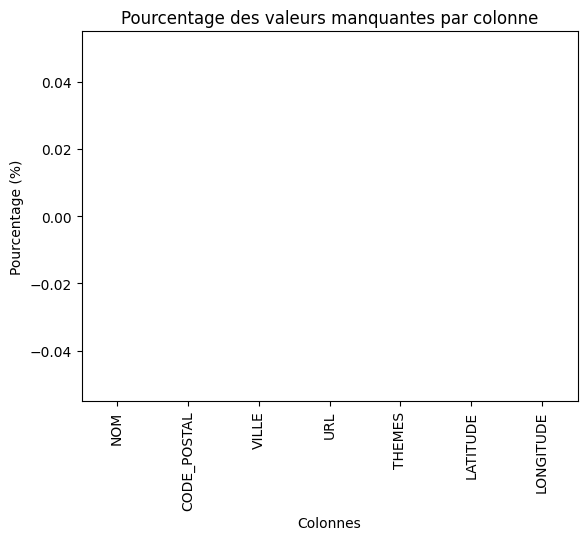

In [ ]:
# Pourcentage de données manquantes par colonnes

# Calcul du pourcentage des valeurs manquantes
missing_percentage = (Musee_de_France.isna().sum() / len(Musee_de_France)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

In [ ]:
# Les thèmes manquant sont remplacés par leur sous-domaine
themes = []

for i in range(len(Musee_de_France.THEMES)):
    if pd.isna(Musee_de_France['THEMES'].iloc[i]):
        themes.append(Musee_de_France['DOMAINE_THEMATIQUE'].iloc[i])
    else:
        themes.append(Musee_de_France['THEMES'].iloc[i])

Musee_de_France.THEMES = themes

In [ ]:
# Suppression des dernières lignes dont le thème est manquant (peu nombreuses)
Musee_de_France=Musee_de_France[~Musee_de_France.THEMES.isna()]

In [ ]:
# Uniformisation des thèmes
# Fonction pour supprimer les accents et renommer les thèmes
def renommer_theme(valeur):
    if isinstance(valeur, str):
        # Normaliser la chaîne pour supprimer les accents
        valeur_normalisee = ''.join(
            c for c in unicodedata.normalize('NFD', valeur.lower())
            if unicodedata.category(c) != 'Mn'
        )
        # Vérifier les mots-clés
        if "archeologie" in valeur_normalisee:
            return "Archeologie"
        elif "arts decoratif" in valeur_normalisee:
            return "Arts décoratif"
        elif any(mot in valeur_normalisee for mot in ["histoire", "historique","medieval","antiquites"]):
            return "Histoire"
        elif any(mot in valeur_normalisee for mot in ["beaux-arts", "historique","Art moderne et contemporain","art","peinture","ceramique","siderurgie","philosophie","autre"]):
            return "Art"
        elif any(mot in valeur_normalisee for mot in ["sciences de la nature","sciences","invertebres"]):
            return "Sciences de la nature"
        elif any(mot in valeur_normalisee for mot in ["civilisations"]):
            return "Histoire"
        elif any(mot in valeur_normalisee for mot in ["ethnologie"]):
            return "Ethnologie"
        elif any(mot in valeur_normalisee for mot in ["musique"]):
            return "Musique"
        elif any(mot in valeur_normalisee for mot in ["industrie"]):
            return "Industrie"
        else:
            return valeur  # Conserver la valeur d'origine
    else:
        return valeur  # Conserver les NaN ou autres types de valeurs

# Appliquer la fonction à la colonne THEMES
Musee_de_France['THEMES'] = Musee_de_France['THEMES'].apply(renommer_theme)


In [ ]:
# Récapitulatif des différents thèmes et leur proportion
Musee_de_France.THEMES.value_counts()

,count
THEMES,
Archeologie,468
Arts décoratif,286
Histoire,205
Art,125
Sciences de la nature,66
Ethnologie,23
Industrie,4
Musique,2
Biographie,2


In [ ]:
# Remplacement des URL Manquants par 'non renseigné'
Musee_de_France.URL = Musee_de_France.URL.fillna("non renseigne")

# Suppression de la colonne 'domaine thématique'
Musee_de_France = Musee_de_France.drop(columns=['DOMAINE_THEMATIQUE'])

In [ ]:
Musee_de_France.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OK_musees-de-france-base-museofile.csv', index=False)

# Liste des sites patrimoniaux remarquables

In [ ]:
# Chargement des données
Patrim_remarq = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/liste-des-sites-patrimoniaux-remarquables-spr.csv',sep=";")

## Sélection des données

In [ ]:
# Sélection des colonnes
col = ['Commune', 'Population\n','Code INSEE']
Patrim_remarq = Patrim_remarq[col]

In [ ]:
# Formatage des noms de colonnes
Patrim_remarq.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", " ")
    for col in Patrim_remarq.columns
]

In [ ]:
# Affectation des noms de colonnes
Patrim_remarq.rename(columns={'POPULATION\n': 'POPULATION'}, inplace=True)

## Gestion des valeurs manquantes

COMMUNE        0.0
POPULATION     0.0
CODE_POSTAL    0.0
dtype: float64


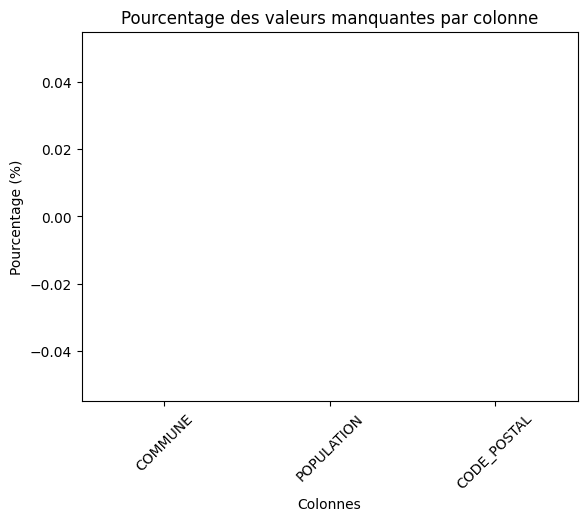

In [ ]:
# Calcul du pourcentage des valeurs manquantes
missing_percentage = (Patrim_remarq.isna().sum() / len(Patrim_remarq)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=45, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

### Ajout des populations manquantes

In [ ]:
data_pop = pd.read_excel('/content/drive/MyDrive/PIP - G6/Donnees/population.xlsx')

Patrim_remarq.drop_duplicates('CODE_INSEE', inplace=True)
Patrim_remarq.reset_index(drop=True, inplace=True)

populations = []
for i in range(len(Patrim_remarq)):
    if pd.isna(Patrim_remarq.POPULATION[i]):
        if str(Patrim_remarq['CODE_INSEE'].iloc[i]) in data_pop['codgeo'].values:
            populations.append(
                data_pop.groupby('codgeo').get_group(Patrim_remarq['CODE_INSEE'].iloc[i]).p21_pop.unique()[0]
            )
        else:
            populations.append(Patrim_remarq.POPULATION[i])
    else:
        populations.append(Patrim_remarq.POPULATION[i])

Patrim_remarq['POPULATION'] = populations

Nous avons remarqués qu'il manquait tout de même des valeurs dans la colonne POPULATION. Nous avons décidé de les ajouter manuellement.

In [ ]:
# Recherche des données manquantes et leur index
Patrim_remarq[Patrim_remarq['POPULATION'].isna()]

,COMMUNE,POPULATION,CODE_INSEE
534,PARIS,NaN,75056
671,LYON,NaN,69123
860,MARSEILLE,NaN,13055


In [ ]:
# Ajout des valeurs
Patrim_remarq.loc[534, 'POPULATION'] = 2133111.0
Patrim_remarq.loc[671, 'POPULATION'] = 528550.0
Patrim_remarq.loc[860, 'POPULATION'] = 873076.0

### Ajout des codes postaux

In [ ]:
# Chargement des données
df_CP = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-officielle-codes-postaux.csv',sep=";")
df_CP = df_CP.drop_duplicates(subset=['code_postal'])

# Séparation des coordonnées en longitude et latitude
df_CP[['LATITUDE', 'LONGITUDE']] = df_CP['_geopoint'].str.split(',', expand=True)
df_CP = df_CP.drop('_geopoint', axis=1)

In [ ]:
# Sélection des colonnes dans la base df_CP
col = ['code_commune_insee', 'code_postal']
df_CP = df_CP[col]

In [ ]:
# Fusion des deux df en fonction du code INSEE
Patrim_remarq = Patrim_remarq.merge(df_CP, how = 'left', left_on = 'CODE_INSEE', right_on = 'code_commune_insee')

# Suppression de la colonne code_commune_insee issue de df_CP
Patrim_remarq = Patrim_remarq.drop('code_commune_insee', axis=1)

In [ ]:
# Ajout des codes postaux
code_postal = []
for code in Patrim_remarq['CODE_INSEE']:
    str_code = str(code)
    if str_code == '13055':
        code_postal.append('13000/13001/13002/13003/13004/13005/13006/13007/13008/13009/13010/13011/13012/13013/13014/13015/13016/13348')
    elif str_code == '69123':
        code_postal.append('69000/69001/69002/69003/69004/69005/69006/69007/69008/69009')
    elif str_code == '6912369259':
        code_postal.append('69000/69001/69002/69003/69004/69005/69006/69007/69008/69009/69200')
    elif str_code == '75056':
        code_postal.append('Paris')
    elif str_code == '7609576540':
        code_postal.append('76420/76000/76100')
    elif str_code == '1305513070':
        code_postal.append('13000/13001/13002/13003/13004/13005/13006/13007/13008/13009/13010/13011/13012/13013/13014/13015/13016/13348/13821')
    elif len(str_code) > 5:
        if str_code[0:5] in df_CP['CODE_INSEE'].values and str_code[5:10] in df_CP['CODE_INSEE'].values:
            code_postal.append(df_CP.groupby('CODE_INSEE').get_group(str_code[0:5])['code_postal'].unique()[0]
                               + "/" +
                               df_CP.groupby('CODE_INSEE').get_group(str_code[5:10])['code_postal'].unique()[0])
        else:
            code_postal.append('None')
    elif code in df_CP['code_commune_insee'].values:
        code_postal.append(df_CP.groupby('code_commune_insee').get_group(code)['code_postal'].unique()[0])
    else:
        code_postal.append('None')

Patrim_remarq['CODE_POSTAL'] = code_postal

In [ ]:
# Récupration des colonnes définitives
col = ['COMMUNE', 'POPULATION', 'CODE_POSTAL']
Patrim_remarq = Patrim_remarq[col]

In [ ]:
Patrim_remarq.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/0K_liste-des-sites-patrimoniaux-remarquables-spr.csv', index=False)

# Liste des édifices labélisés "architecture contemporaine remarquable"

In [ ]:
# Chargement des données
Edifices_archi_contemp = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/liste-des-edifices-labellises-architecture-contemporaine-remarquable-acr.csv',sep=";")

## Séléction des données

In [ ]:
# Sélection des colonnes
col = ['Titre_courant', 'Commune', 'Coordonnees', 'Dénominations', 'INSEE']
Edifices_archi_contemp = Edifices_archi_contemp[col]


In [ ]:
# Formatage des noms de colonnes
Edifices_archi_contemp.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", " ")
    for col in Edifices_archi_contemp.columns
]

In [ ]:
# Séparation des coordonnées en longitude et latitude
Edifices_archi_contemp[['LATITUDE', 'LONGITUDE']] = Edifices_archi_contemp['COORDONNEES'].str.split(',', expand=True)
Edifices_archi_contemp = Edifices_archi_contemp.drop('COORDONNEES', axis=1)

In [ ]:
# Affectation des noms
Edifices_archi_contemp = Edifices_archi_contemp.rename(columns={'TITRE_COURANT': 'NOM',
                                                                'DENOMINATIONS' : 'THEMES'})

## Ajout des codes postaux


In [ ]:
# Chargement des données
df_CP = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-officielle-codes-postaux.csv',sep=";")
df_CP = df_CP.drop_duplicates(subset=['code_postal'])

In [ ]:
# Sélection des colonnes dans la base df_CP
col = ['code_commune_insee', 'code_postal']
df_CP = df_CP[col]

In [ ]:
# Fusion des deux df en fonction du code INSEE
Edifices_archi_contemp = Edifices_archi_contemp.merge(df_CP, how = 'left', left_on = 'INSEE', right_on = 'code_commune_insee')

# Suppression de la colonne code_commune_insee issue de df_CP
Edifices_archi_contemp = Edifices_archi_contemp.drop('code_commune_insee', axis=1)

### Gestion des codes postaux manquants

In [ ]:
# Suppression des lignes dont il manque les codes postaux
Edifices_archi_contemp = Edifices_archi_contemp[~Edifices_archi_contemp.code_postal.isna()]

## Gestion des valeurs manquantes

NOM          0.0
THEMES       0.0
COMMUNE      0.0
LATITUDE     0.0
LONGITUDE    0.0
dtype: float64


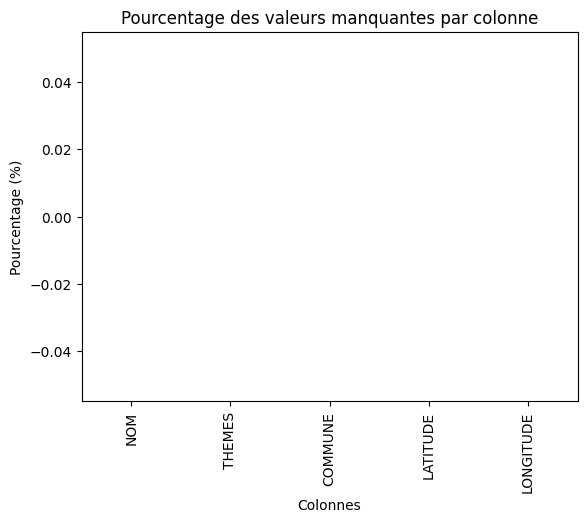

In [ ]:
# Pourcentage de données manquantes par colonnes

# Calcul du pourcentage des valeurs manquantes
missing_percentage = (Edifices_archi_contemp.isna().sum() / len(Edifices_archi_contemp)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

### Gestion des Communes manquantes

In [ ]:
# Suppression des lignes dont la commune est manquante (très peu, 0.05%)
Edifices_archi_contemp = Edifices_archi_contemp[~Edifices_archi_contemp.COMMUNE.isna()]

### Gestion des coordonnées géographiques manquantes

In [ ]:
# Chargement des données
df_coord = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/base-officielle-codes-postaux.csv',sep=";")
df_coord = df_coord.drop_duplicates(subset=['code_commune_insee'])

# Séparation des coordonnées en longitude et latitude
df_coord[['LATITUDE', 'LONGITUDE']] = df_coord['_geopoint'].str.split(',', expand=True)
df_coord = df_coord.drop('_geopoint', axis=1)

col = ['code_commune_insee', 'LATITUDE', 'LONGITUDE']
df_coord = df_coord[col]


In [ ]:
# Séparation de la df pour gérer les manquants
df_sans_nan = Edifices_archi_contemp[~Edifices_archi_contemp.LATITUDE.isna()]
df_avec_nan = Edifices_archi_contemp[Edifices_archi_contemp.LATITUDE.isna()]

In [ ]:
# Merge sur le code commune INSEE pour ajouter les valeurs manquantes
df_avec_nan = df_avec_nan.merge(df_coord, how = 'left', left_on = 'INSEE', right_on = 'code_commune_insee')

# On récupère les bonnes colonnes
col = ['NOM', 'THEMES','COMMUNE', 'LATITUDE_y', 'LONGITUDE_y']
df_avec_nan = df_avec_nan[col]

# On renomme les colonnes
df_avec_nan = df_avec_nan.rename(columns={'LATITUDE_y': 'LATITUDE'})
df_avec_nan = df_avec_nan.rename(columns={'LONGITUDE_y': 'LONGITUDE'})

In [ ]:
# Re fusion des deux parties
col = ['NOM', 'THEMES','COMMUNE', 'LATITUDE', 'LONGITUDE']
df_sans_nan = df_sans_nan[col]
Edifices_archi_contemp = pd.concat([df_avec_nan, df_sans_nan])

## Gestion des Thèmes

In [ ]:
# Liste des différents thèmes et leur nombre d'apparition
Edifices_archi_contemp.THEMES.value_counts()

,count
THEMES,
"architecture religieuse,édifice religieux,édifice religieux chrétien,église",183
"architecture domestique,édifice domestique,demeure,maison",141
"architecture domestique,édifice domestique,demeure,immeuble",114
"urbanisme et espaces aménagés,secteur urbain,secteur urbain concerté,lotissement",111
"architecture scolaire,édifice scolaire,école,groupe scolaire",95
...,...
"urbanisme et espaces aménagés,secteur urbain,quartier,forum",1
"architecture de culture recherche sport ou loisir,édifice et aménagement de culture recherche sport ou loisir,camping",1
"génie civil,ensemble du génie civil,gare de triage",1


On remarque qu'il y a énormément de thèmes différents et certains sont très similaires.

In [ ]:
# Fonction pour supprimer les accents et uniformiser les catégories
def simplifier_themes(valeur):
    if isinstance(valeur, str):
        # Normaliser la chaîne pour supprimer les accents
        valeur_normalisee = ''.join(
            c for c in unicodedata.normalize('NFD', valeur.lower())
            if unicodedata.category(c) != 'Mn'
        )
        # Vérifier les mots-clés et retourner une catégorie simplifiée
        if any(mot in valeur_normalisee for mot in ["religieuse", "edifice religieux", "eglise", "mosquee", "synagogue", "conventuel", "paroissial"]):
            return "Religieux"
        elif any(mot in valeur_normalisee for mot in ["domestique", "demeure", "maison", "immeuble", "logements", "urbanisme", "parc", "jardin", "secteur urbain", "lotissement", "quartier", "grand ensemble", "centre-ville", "technopole", "village", "cité"]):
            return "Habitation et Espaces urbains"
        elif any(mot in valeur_normalisee for mot in ["scolaire", "ecole", "universite", "lycee", "primaire", "secondaire", "professionnelle", "enseignement superieur", "campus"]):
            return "Éducation"
        elif any(mot in valeur_normalisee for mot in ["bibliotheque", "centre culturel", "cinema", "gymnase", "musee", "piscine", "complexe sportif", "congres", "fetes", "auditorium", "theatre", "exposition", "archives", "observatoire", "village de vacances", "culture" ,"station balneaire", "station de sports d'hiver"]):
            return "Culture et loisirs"
        elif any(mot in valeur_normalisee for mot in ["poste", "mairie", "hotel de ville", "prefecture", "administratif", "administration", "chambre de commerce", "hotel de departement", "association", "tribunal", "commissariat", "fiscal"]):
            return "Administrations et services publics"
        elif any(mot in valeur_normalisee for mot in ["hopital", "social", "foyer", "protection sociale"]):
            return "Santé et assistance"
        elif any(mot in valeur_normalisee for mot in ["marche", "banque", "commerce", "restaurant", "station service", "abattoir", "garage", "galerie marchande", "artisanal", "artisanat"]):
            return "Commerce et artisanat"
        elif any(mot in valeur_normalisee for mot in ["pont", "reservoir", "ouvrage d'art", "gare",  "genie civil"]):
            return "Génie civil"
        elif any(mot in valeur_normalisee for mot in ["usine", "entrepot", "minoterie", "vinicole", "papeterie", "construction", "industriel"]):
            return "Industriel"
        elif any(mot in valeur_normalisee for mot in ["militaire", "casemate", "batterie", "fortifie"]):
            return "Militaire"
        elif any(mot in valeur_normalisee for mot in ["monument", "commemoratif", "monument aux morts"]):
            return "Monuments commémoratifs"
        elif any(mot in valeur_normalisee for mot in ["agricole"]):
            return "Agricole"
        else:
            return valeur  # Catégorie par défaut pour les cas non couverts
    else:
        return valeur  # Conserver les NaN ou autres types de valeurs

# Appliquer la fonction à la colonne TYPE
Edifices_archi_contemp['THEMES'] = Edifices_archi_contemp['THEMES'].apply(simplifier_themes)



In [ ]:
# Liste des nouveaux thèmes et leur nombre d'apparition
Edifices_archi_contemp.THEMES.value_counts()

,count
THEMES,
Habitation et Espaces urbains,724
Éducation,332
Culture et loisirs,248
Religieux,214
Administrations et services publics,128
Commerce et artisanat,107
Génie civil,81
Industriel,64
Santé et assistance,48


In [ ]:
Edifices_archi_contemp.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/OK_liste-des-edifices-labellises-architecture-contemporaine-remarquable-acr.csv', index=False)

# Bibliothèques des collectivités territoriales

In [ ]:
# Chargement des données
Adress_biblio = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/adresses-des-bibliotheques-publiques.csv', sep=';')

In [ ]:
# Formatage des noms de colonnes
Adress_biblio.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", " ")
    for col in Adress_biblio.columns
]

## Sélection des colonnes

In [ ]:
# On garde uniquement les colonnes qui nous intéresse
col = ['CP', 'SURFACE', 'NOM_DE_L ETABLISSEMENT', 'VILLE', 'STATUT', 'NOMBRE_DE_SALARIES', 'NOMBRE_DE_BENEVOLES', 'LONGITUDE', 'LATITUDE', 'CODE_INSEE_COMMUNE']
Adress_biblio = Adress_biblio[col]

In [ ]:
# On renome les colonnes
Adress_biblio = Adress_biblio.rename(columns={'CP': 'CODE_POSTAL',
                                    'ETABLISSEMENT': 'NOM'})

## Gestion des valeurs manquantes

CODE_POSTAL               0.0
SURFACE                   0.0
NOM_DE_L ETABLISSEMENT    0.0
VILLE                     0.0
STATUT                    0.0
NOMBRE_DE_SALARIES        0.0
NOMBRE_DE_BENEVOLES       0.0
LONGITUDE                 0.0
LATITUDE                  0.0
CODE_INSEE_COMMUNE        0.0
dtype: float64


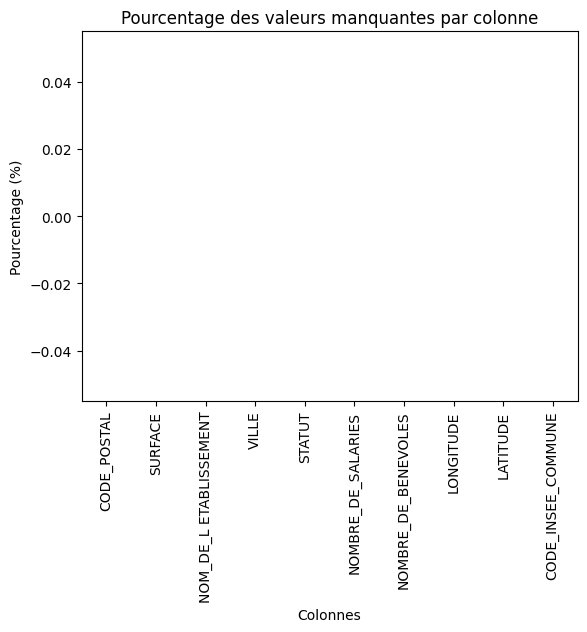

In [ ]:
# Pourcentage de données manquantes par colonnes

# Calcul du pourcentage des valeurs manquantes
missing_percentage = (Adress_biblio.isna().sum() / len(Adress_biblio)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

### Gestion des surfaces manquantes

In [ ]:
# Remplacement des valeurs manquantes de Surface par la moyenne
m = np.mean(Adress_biblio.SURFACE)
for i in range (len(Adress_biblio)):
    if Adress_biblio.loc[i, 'SURFACE'] == 0.0 :
      Adress_biblio.loc[i, 'SURFACE'] = m
Adress_biblio.SURFACE = Adress_biblio.SURFACE.fillna(m)


### Gestion des nombre des bélévoles et salariés manquant

In [ ]:
# On met à 0 les valeurs manquantes de nombre_de_bélévoles
Adress_biblio.NOMBRE_DE_BENEVOLES = Adress_biblio.NOMBRE_DE_BENEVOLES.fillna(0)

# Suppression des lignes où nombre_de_salarié est vide et où nombre_de_salariés et nombre_de_bélévoles est à 0.
Adress_biblio = Adress_biblio[(~Adress_biblio.NOMBRE_DE_SALARIES.isna()) & ~((Adress_biblio.NOMBRE_DE_SALARIES==0)&(Adress_biblio.NOMBRE_DE_BENEVOLES==0))]

### Gestion des codes postaux manquants

In [ ]:
# Nombre de codes postaux manquants
Adress_biblio['CODE_POSTAL'].isna().sum()

1

In [ ]:
# Suppression de la ligne dont il manque le code postal
Adress_biblio = Adress_biblio[(~Adress_biblio.CODE_POSTAL.isna())]

### Gestion des coordonnées géographiques manquantes

In [ ]:
# Nombre de coordonnées manquantes
Adress_biblio['LATITUDE'].isna().sum()

317

In [ ]:
# Suppression des lignes où les coordonnées et le code INSEE sont manquants
Adress_biblio = Adress_biblio[(~Adress_biblio.LATITUDE.isna()) & (~Adress_biblio.CODE_INSEE_COMMUNE.isna())]

In [ ]:
# Nombre de coordonnées manquantes restantes
Adress_biblio['LATITUDE'].isna().sum()

0

On ne pourra pas retrouver les coordonnées géographiques des bibliothèques sans le code INSEE de la commune donc on supprime ces lignes. On remarque qu'il ne reste plus de lignes manquantes donc nous n'avons pas besoin de faire de fusion avec df_coord pour compléter nos données.

## Gestion des accents dans les noms des villes


In [ ]:
# On réindexe les données
Adress_biblio.reset_index(drop=True, inplace=True)


list_of_changes = [
    (' *', ''),
    ('É', 'E'),
    ('È', 'E'),
    ('Ê', 'E'),
    ('Ë', 'E'),
    ('Á', 'A'),
    ('Â', 'A'),
    ('À', 'A'),
    ('Ô', 'O'),
    ('Ù', 'U'),
    ('Î', 'I'),
    ('Ï', 'I'),
    (' ', '_'),
    ("\'", '_'),
    (',', ''),
    ('’', '_')]

def replace_multiple(string, l):
    for i in range(len(l)):
        string = string.replace(l[i][0], l[i][1])
    return string


for i in range(len(Adress_biblio)):
    Adress_biblio.loc[i, 'VILLE'] = replace_multiple(Adress_biblio.loc[i, 'VILLE'].upper(), list_of_changes)

In [ ]:
Adress_biblio.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/OKOK-adresses-des-bibliotheques-publiques.csv', index=False)

# Liste des Festivals en France

In [ ]:
# Chargement des données
festival = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/festivals-global-festivals-_-pl.csv',sep=";")

In [ ]:
# Formatage des noms de colonnes
festival.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", " ")
    for col in festival.columns
]

## Sélection des données

In [ ]:
# Sélection des colonnes
col=['NOM_DU_FESTIVAL','CODE_POSTAL_(DE_LA_COMMUNE_PRINCIPALE_DE_DEROULEMENT)','COMMUNE_PRINCIPALE_DE_DEROULEMENT','SITE_INTERNET_DU_FESTIVAL','DISCIPLINE_DOMINANTE','GEOCODAGE_XY']
festival=festival[col]

In [ ]:
# Séparation des coordonnées en longitude et latitude
festival[['LATITUDE', 'LONGITUDE']] = festival['GEOCODAGE_XY'].str.split(',', expand=True)
festival = festival.drop('GEOCODAGE_XY', axis=1)


In [ ]:
# Affectation des noms
festival = festival.rename(columns={'CODE_POSTAL_(DE_LA_COMMUNE_PRINCIPALE_DE_DEROULEMENT)': 'CODE_POSTAL',
                                    'COMMUNE_PRINCIPALE_DE_DEROULEMENT': 'COMMUNE',
                                    'SITE_INTERNET_DU_FESTIVAL': 'URL',
                                    'DISCIPLINE_DOMINANTE': 'TYPE',
                                    'NOM_DU_FESTIVAL' : 'NOM'})

## Gestion des valeurs manquantes

NOM            0.0
CODE_POSTAL    0.0
COMMUNE        0.0
URL            0.0
TYPE           0.0
LATITUDE       0.0
LONGITUDE      0.0
dtype: float64


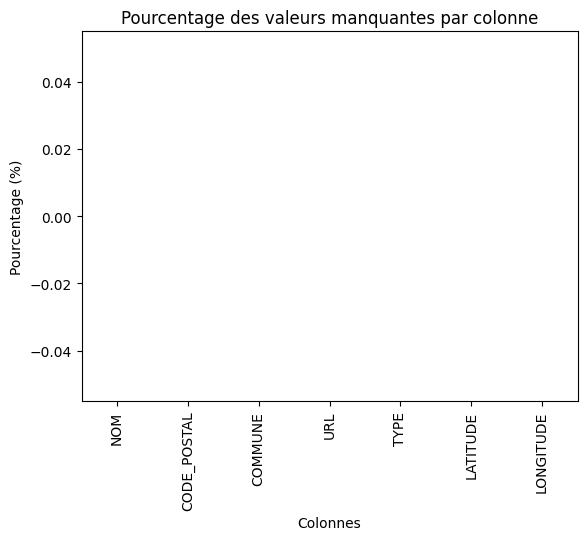

In [ ]:
# Calcul du pourcentage des valeurs manquantes
missing_percentage = (festival.isna().sum() / len(festival)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

### Gestion des URL manquants

In [ ]:
# Remplacement des URL Manquants par 'non renseigné'
festival.URL = festival.URL.fillna("non renseigne")

### Gestion des coordonnées manquantes

In [ ]:
# Nombre de villes manquantes
festival['LATITUDE'].isna().sum()

33

In [ ]:
# Suppression des lignes dont il manque les coordonnées
festival = festival[~festival.LATITUDE.isna()]

Nous avons esayés de fusionner nore dataframe avec une autre base de donnée mais nous ne gagnons d'une ligne. Pour cette raison, nous avons décidés de supprimer toutes les lignes où l'information était manquante.

### Gestion des Codes Postaux manquants

In [ ]:
# Nombre de codes postaux manquants
festival['CODE_POSTAL'].isna().sum()

1

In [ ]:
# Suppression de la ligne dont il manque le code postal
festival = festival[~festival.CODE_POSTAL.isna()]

### Gestion des Communes manquantes

In [ ]:
# Nombre de Villes manquantes
festival['COMMUNE'].isna().sum()

4

In [ ]:
# Suppression des lignes dont il manque la ville (seulement 4)
festival = festival[~festival.COMMUNE.isna()]

In [ ]:
festival.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/OKOKfestivals-global-festivals-_-pl.csv', index=False)

# Culture Chez Nous

In [ ]:
# Chargement des données
cult_chez_nous = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/culturecheznous.csv', sep=';')

In [ ]:
# Formatage des noms de colonnes
cult_chez_nous.columns = [
    unidecode.unidecode(col).upper().replace(' ', '_').replace("'", " ")
    for col in cult_chez_nous.columns
]

## Sélection des données

In [ ]:
# Sélection des colonnes
col = ['NOM_DE_L ORGANISME','CODE_POSTAL','COMMUNE','GEOLOCALISATION_BAN','PUBLIC_CIBLE','THEMATIQUES','ORGANISME_DE_RATTACHEMENT', 'LIEN_VERS_LA_RESSOURCE']
cult_chez_nous = cult_chez_nous[col]


In [ ]:
# Séparation des coordonnées en longitude et latitude
cult_chez_nous[['LATITUDE', 'LONGITUDE']] = cult_chez_nous['GEOLOCALISATION_BAN'].str.split(',', expand=True)
cult_chez_nous = cult_chez_nous.drop('GEOLOCALISATION_BAN', axis=1)

In [ ]:
# Affectation des noms
cult_chez_nous = cult_chez_nous.rename(columns={'LIEN_VERS_LA_RESSOURCE': 'URL',
                                    'THEMATIQUES': 'THEMES',
                                    'NOM_DE_L ORGANISME' : 'NOM'})

## Gestion des données manquantes

NOM                          0.0
CODE_POSTAL                  0.0
COMMUNE                      0.0
PUBLIC_CIBLE                 0.0
THEMES                       0.0
ORGANISME_DE_RATTACHEMENT    0.0
URL                          0.0
LATITUDE                     0.0
LONGITUDE                    0.0
dtype: float64


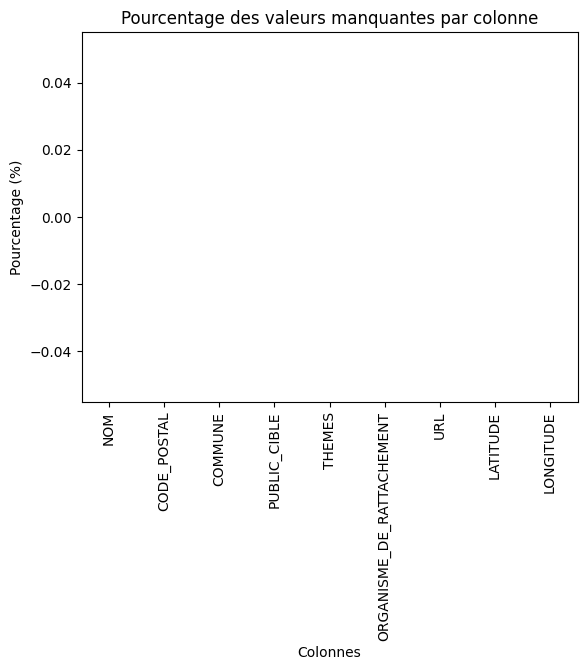

In [ ]:
# Pourcentage de données manquantes par colonnes

# Calcul du pourcentage des valeurs manquantes
missing_percentage = (cult_chez_nous.isna().sum() / len(cult_chez_nous)) * 100

# Affichage des valeurs manquantes en pourcentage
print(missing_percentage)

# Création du graphique
missing_percentage.plot(kind='bar', rot=90, color='skyblue')
plt.title("Pourcentage des valeurs manquantes par colonne")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Colonnes")
plt.show()

### Gestion des Publics cibles manquants

In [ ]:
# On affecte par défaut tous publics aux données manquantes
cult_chez_nous.PUBLIC_CIBLE = cult_chez_nous.PUBLIC_CIBLE.fillna("Tous publics")

## Gestion des Thèmes

In [ ]:
# Affichage de tous les thèmes présents
cult_chez_nous.THEMES.value_counts()

,count
THEMES,
"Littérature, sciences humaines, langues",68
Archives,60
"Musique, concerts et opéras",58
Éducation aux médias,51
Musées,49
...,...
"Histoire,Photographie",1
"Audiovisuel,Musées",1
"Archéologie,Monuments historiques,Musées,Peinture,Sculpture",1


In [ ]:
# Fonction pour supprimer les accents et renommer les thèmes
def renommer_theme(valeur):
    if isinstance(valeur, str):
        # Normaliser la chaîne pour supprimer les accents
        valeur_normalisee = ''.join(
            c for c in unicodedata.normalize('NFD', valeur.lower())
            if unicodedata.category(c) != 'Mn'
        )
        # Vérifier les mots-clés
        if "archeologie" in valeur_normalisee:
            return "Archeologie"
        elif "arts decoratif" in valeur_normalisee:
            return "Arts décoratif"
        elif any(mot in valeur_normalisee for mot in ["histoire", "historique","medieval","antiquites"]):
            return "Histoire"
        elif any(mot in valeur_normalisee for mot in ["beaux-arts", "historique","Art moderne et contemporain","art","peinture","ceramique","siderurgie","philosophie","autre"]):
            return "Art"
        elif any(mot in valeur_normalisee for mot in ["sciences de la nature","sciences","invertebres"]):
            return "Sciences de la nature"
        elif any(mot in valeur_normalisee for mot in ["civilisations"]):
            return "Histoire"
        elif any(mot in valeur_normalisee for mot in ["ethnologie"]):
            return "Ethnologie"
        elif any(mot in valeur_normalisee for mot in ["musique"]):
            return "Musique"
        elif any(mot in valeur_normalisee for mot in ["industrie"]):
            return "Industrie"
        elif any(mot in valeur_normalisee for mot in ["cinema", "audiovisuel","cinema,theatre, spectacles"]):
            return "Cinéma"
        elif any(mot in valeur_normalisee for mot in ["sculpture"]):
            return "Sculpture"
        elif any(mot in valeur_normalisee for mot in ["photographie"]):
            return "Photographie"
        elif any(mot in valeur_normalisee for mot in ["jardin"]):
            return "Parc et Jardin"
        elif any(mot in valeur_normalisee for mot in ["archives", "archives,musées"]):
            return "Archives"
        elif any(mot in valeur_normalisee for mot in ["architecture et patrimoine", "architecture et patrimoine,musees"]):
            return "Architecture et Patrimoine"
        elif any(mot in valeur_normalisee for mot in ["theatre, spectacles"]):
            return "Théâtre et Spectacles"
        else:
            return valeur  # Conserver la valeur d'origine
    else:
        return valeur  # Conserver les NaN ou autres types de valeurs

cult_chez_nous['THEMES'] = cult_chez_nous['THEMES'].apply(renommer_theme)

In [ ]:
cult_chez_nous.THEMES.value_counts()

,count
THEMES,
Art,252
Histoire,199
Sciences de la nature,135
Musique,85
Arts décoratif,72
Archeologie,69
Archives,61
Éducation aux médias,51
Musées,49


In [ ]:
# Standardisaiton des noms de commune

# On place le contenu entre parenthèse au début
cult_chez_nous['COMMUNE'] = cult_chez_nous['COMMUNE'].str.replace(r'(.*) \((.*)\)', r'\2 \1', regex=True)

# Simplification des noms de communes contenant Paris
cult_chez_nous['COMMUNE'] = cult_chez_nous['COMMUNE'].str.replace(r'.*\bParis\b.*', 'Paris', flags=re.IGNORECASE, regex=True)

# Suppression des caractères dans les noms
nom_col = 'COMMUNE'

list_of_changes = [
    (',', ''),
    ("\'", '_'),
                   ]
def replace_multiple(string, l):
    for i in range(len(l)):
        string = string.replace(l[i][0], l[i][1])
    return string

for i in range(len(cult_chez_nous)):
    str_to_change = str(cult_chez_nous.loc[i, nom_col])
    str_changed = replace_multiple(str_to_change.upper(), list_of_changes)
    cult_chez_nous.loc[i, nom_col] = str_changed



In [ ]:
cult_chez_nous.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/OK_culturecheznous.csv',index=False)

# Revenus par commune

In [ ]:
# Chargement des données
revenu = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/revcommunes.csv')

<ipython-input-507-b16e43f5be46>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  revenu = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/revcommunes.csv')


## Sélection des données

In [ ]:
# Sélection des colonnes
revenu = revenu[[ 'codecommune', 'dep', 'nomcommune', 'nomdep', 'paris', 'revmoy2022', 'revtot2022', 'nadult2022', 'nfoyer2022', 'revmoyfoy2022' ]]

In [ ]:
revenu.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/OK_rev_communes.csv', index=False)

# Dépenses culturelles par département

In [ ]:
# Chargement des données
dep_cult = pd.read_csv('/content/drive/MyDrive/PIP - G6/Donnees/depenses-culturelles-des-departements-total.csv', sep=';')

## Sélection des données

In [ ]:
dep_cult = dep_cult.groupby('Année').get_group(2020)

In [ ]:
# Sélection des colonnes
dep_cult.rename(columns={'Année': 'ANNEE',
             'Code_insee': 'CODE_INSEE',
             'Libellé_géographique': 'DEPARTEMENT',
             'Dépenses culturelles totales (€)' : 'DEPENSES_TOT',
             'Dépenses culturelles totales par habitant (€)' : 'DEPENSES_TOT_HAB',
             'Effort budgétaire total (%)': 'EFFORT_BUDGET_TOT'}, inplace=True)
col = ['ANNEE', 'CODE_INSEE', 'DEPARTEMENT', 'DEPENSES_TOT', 'DEPENSES_TOT_HAB', 'EFFORT_BUDGET_TOT']
dep_cult = dep_cult[col]

In [ ]:
# Réindexation
dep_cult.reset_index(drop=True, inplace=True)

## Gestion des accents et des caractères dans les données

In [ ]:
list_of_changes = [
    (' *', ''),
    ('É', 'E'),
    ('È', 'E'),
    ('Ê', 'E'),
    ('Ë', 'E'),
    ('Á', 'A'),
    ('Â', 'A'),
    ('À', 'A'),
    ('Ô', 'O'),
    ('Ù', 'U'),
    ('Î', 'I'),
    ('Ï', 'I'),
    (' ', '_'),
    ("\'", '_'),
    (',', ''),
    ('’', '_')
                   ]
def replace_multiple(string, l):
    for i in range(len(l)):
        string = string.replace(l[i][0], l[i][1])
    return string

for i in range(len(dep_cult)):
    dep_cult.loc[i, 'DEPARTEMENT'] = replace_multiple(dep_cult.loc[i, 'DEPARTEMENT'].upper(), list_of_changes)

In [ ]:
dep_cult.to_csv('/content/drive/MyDrive/PIP - G6/Donnees propres/OKOKdonnées/depenses-culturelles-des-departements-total.csv',index=False)